<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
%pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 119.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# %pip install -r requirements.txt

In [4]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [5]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [6]:
import requests
from pathlib import Path

In [7]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [8]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [9]:
!head -n 50 {emerson_file}

﻿The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                    

In [10]:
!head -n 50 {thoreau_file}

﻿The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and 

In [11]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [12]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [13]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [14]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [15]:
from collections import deque
from random import randint
import itertools


In [16]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [17]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [18]:
import pandas as pd

In [19]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [20]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1073 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [21]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,He was descended\n\nfrom a long line of New En...
2,"He was always serene and\n\nthoughtful, impres..."
3,"As a preacher, Emerson was interesting,\n\ntho..."
4,"A\n\nconnoisseur in such matters, an old sexto..."


In [22]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    841 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [23]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,"In most books, the _I_, or first person,\n\nis..."
2,Perhaps these pages are more\n\nparticularly a...
3,I have travelled a good deal in Concord;\n\nan...
4,Who made them\n\nserfs of the soil? Why should...


In [24]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1914 entries, 146 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1914 non-null   object
 1   label   1914 non-null   object
dtypes: object(2)
memory usage: 44.9+ KB


,text,label
146,"If they\n\ncannot understand that, they cannot...",thoreau
638,Life wastes itself whilst we are\n\npreparing ...,emerson
521,I took up the chip on which the three I have p...,thoreau
409,The popular notion certainly adds a condition ...,emerson
31,we_ know so much of\n\nthem as we do. The same...,thoreau


## Now we have our dataset in combined.csv


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

<ipython-input-27-3711010374>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


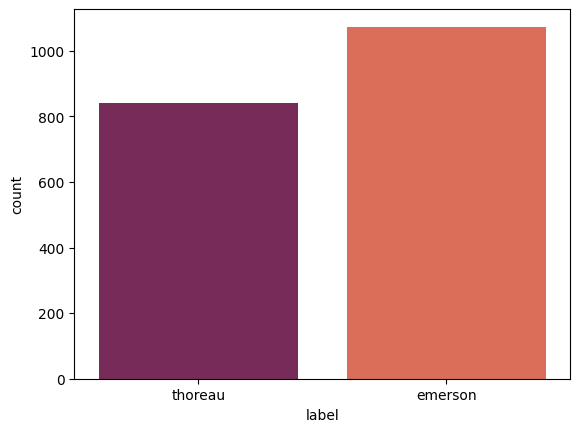

In [27]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [28]:
%pip install -q wordcloud

In [29]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"'s, all, regarding, there, my, seemed, others, our, via, an, unless, ever, someone, least, be, used, make, you, now, front, around, should, wherein, about, its, along, nothing, throughout, sometimes, please, doing, seeming, herself, top, eleven, through, mine, anyone, everyone, into, formerly, both, rather, will, six, together, though, up, alone, sometime, until, at, serious, amongst, whether, just, i, never, may, could, elsewhere, therein, also, yourselves, often, every, they, ’re, some, ‘ve, how, becomes, thus, whither, back, give, mostly, myself, well, even, meanwhile, forty, nowhere, does, have, hers, twenty, moreover, out, upon, his, we, take, whereafter, latterly, besides, thereupon, within, really, somewhere, two, would, ‘d, whereby, during, full, without, four, where, no, by, thereafter, ‘s, noone, somehow, per, already, same, the, another, only, onto, either, perhaps, show, behind, 'll, against, first, 'd, many, still, beforehand, side, too, whenever, those, this, get, for, w

In [30]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




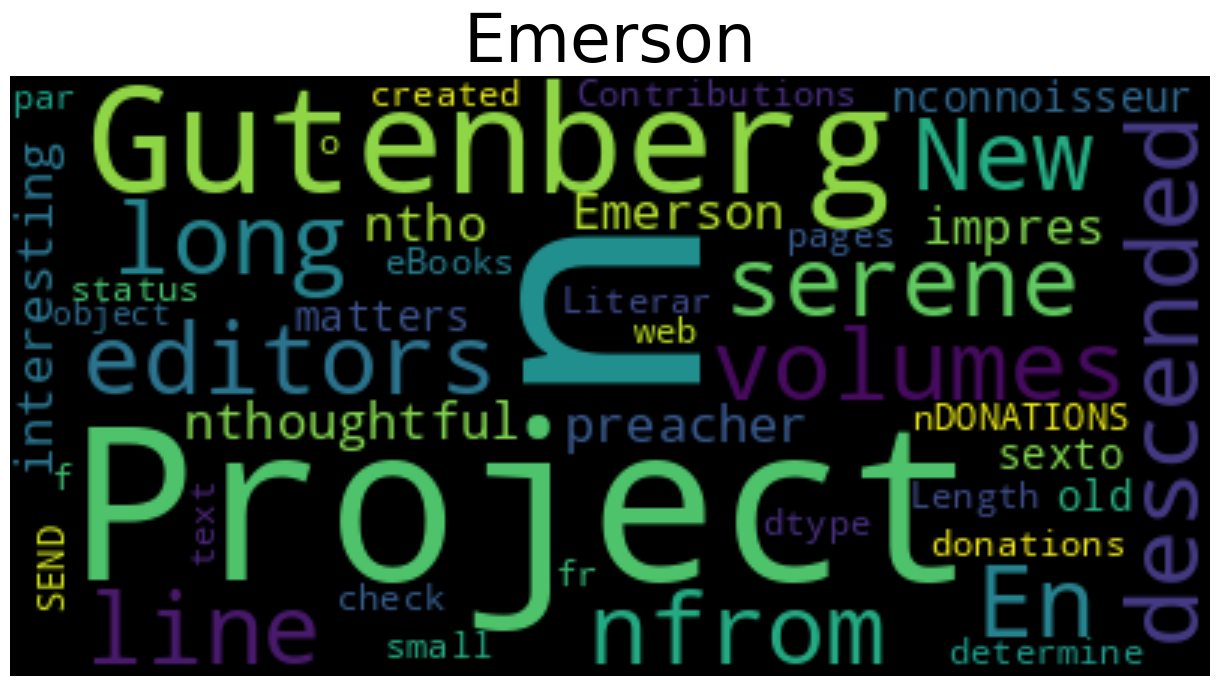

In [31]:
plot_word_cloud(emerson_df["text"], "Emerson")

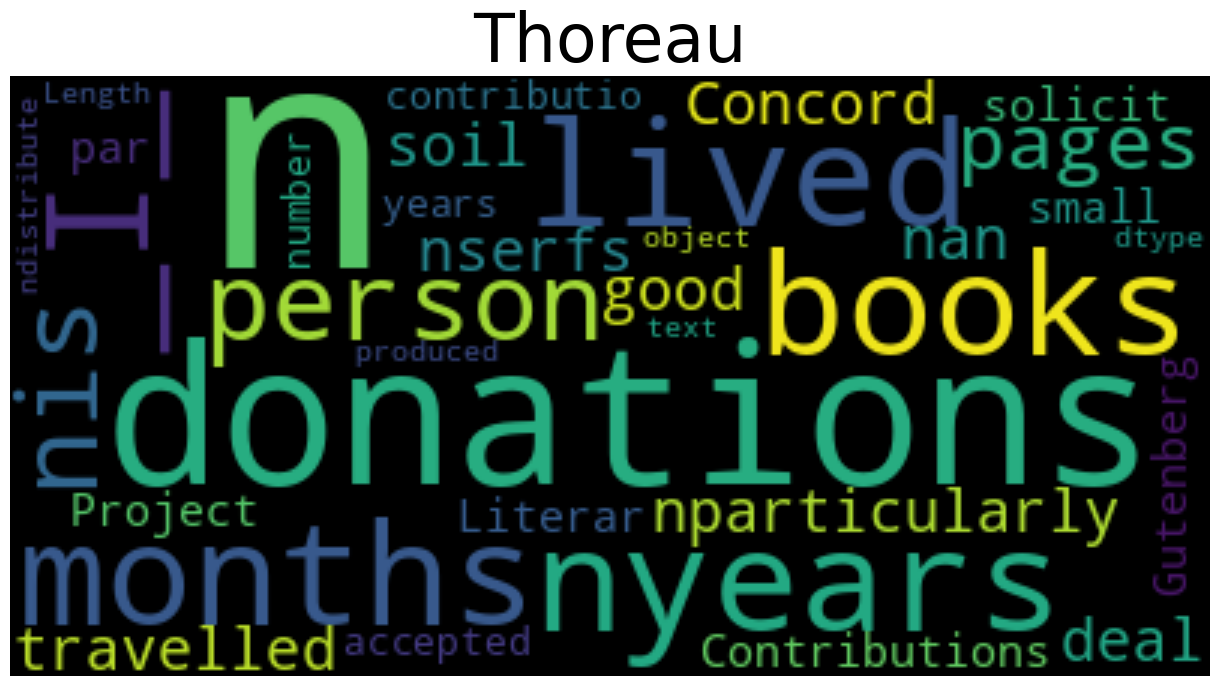

In [32]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

## Traditional (Non-Transformer) Models

In [33]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [34]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
146,"If they\n\ncannot understand that, they cannot...",thoreau,\n\n understand understand \n\n glad hear exp...
638,Life wastes itself whilst we are\n\npreparing ...,emerson,life waste whilst \n\n prepare live friend fel...
521,I took up the chip on which the three I have p...,thoreau,take chip particularly describe \n\n struggle ...
409,The popular notion certainly adds a condition ...,emerson,popular notion certainly add condition ease \n...
31,we_ know so much of\n\nthem as we do. The same...,thoreau,know \n\n true modern reformer \n\n benefactor...


In [35]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [36]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1531, 11836)
y_train: (1531,)
x_test: (383, 11836)
y_test: (383,)


In [37]:
from sklearn.linear_model import LogisticRegression


In [38]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [39]:
y_pred = lr_model.predict(x_test)

In [40]:
from sklearn.metrics import f1_score

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.80      0.90      0.85       201
     thoreau       0.87      0.75      0.80       182

    accuracy                           0.83       383
   macro avg       0.83      0.82      0.83       383
weighted avg       0.83      0.83      0.83       383

Test accuracy: 0.8276762402088773


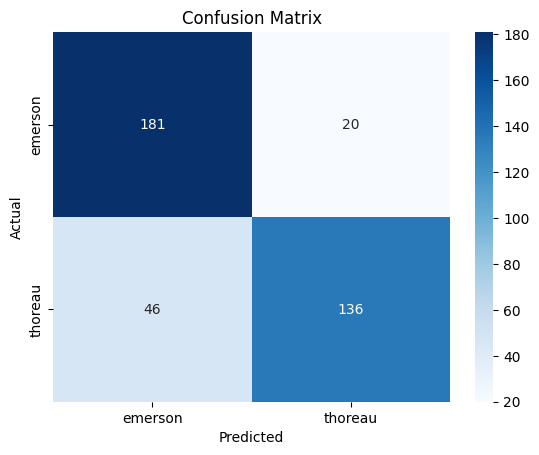

In [42]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [43]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [44]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.79      0.87      0.83       201
     thoreau       0.84      0.75      0.79       182

    accuracy                           0.81       383
   macro avg       0.82      0.81      0.81       383
weighted avg       0.81      0.81      0.81       383

Test accuracy: 0.8120104438642297


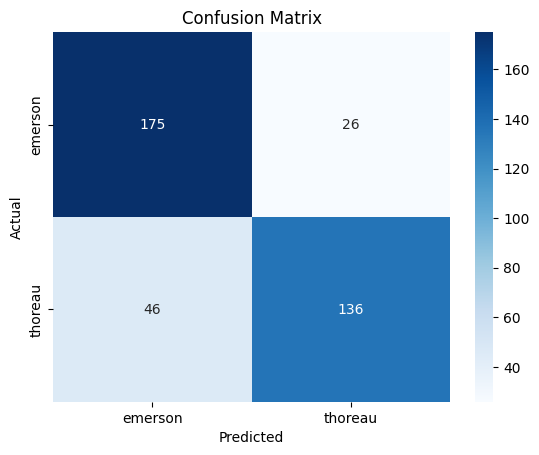

In [45]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [46]:
from sklearn import svm

In [47]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [48]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.81      0.90      0.85       201
     thoreau       0.87      0.76      0.81       182

    accuracy                           0.83       383
   macro avg       0.84      0.83      0.83       383
weighted avg       0.84      0.83      0.83       383

Test accuracy: 0.8328981723237598


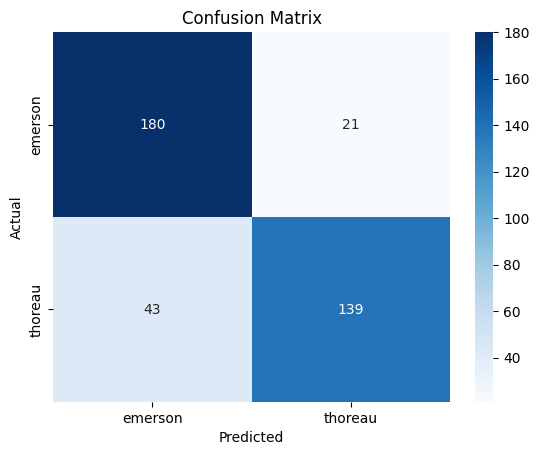

In [49]:
show_metrics(y_test, y_pred_svm, "SVM")

In [50]:
# TODO: if not colab
#%pip install -q transformers

In [51]:
# TODO: if not colab
#%pip install -q torch

In [52]:
import torch

In [53]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [54]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [55]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1531,)
y_train_s: (1531,)
x_test_s: (383,)
y_test_s: (383,)


In [56]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [57]:
x_train_tok[0:2]

[Encoding(num_tokens=492, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=492, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [58]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-58-3140837852>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-58-3140837852>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [59]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [60]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [61]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.92      0.93      0.92       201
     thoreau       0.92      0.91      0.91       182

    accuracy                           0.92       383
   macro avg       0.92      0.92      0.92       383
weighted avg       0.92      0.92      0.92       383

Test accuracy: 0.9190600522193212


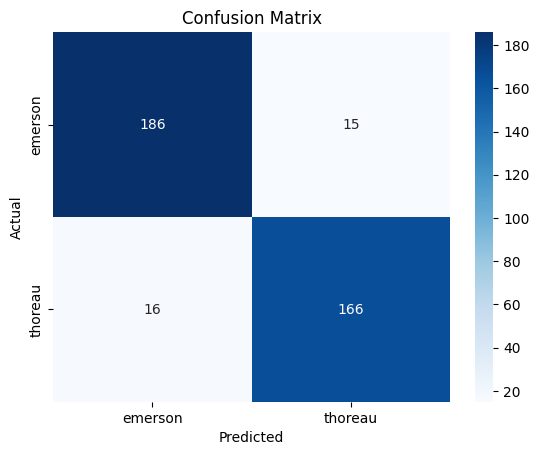

In [62]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [63]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.84      0.93      0.88       201
     thoreau       0.91      0.80      0.85       182

    accuracy                           0.87       383
   macro avg       0.88      0.87      0.87       383
weighted avg       0.87      0.87      0.87       383

Test accuracy: 0.8694516971279374


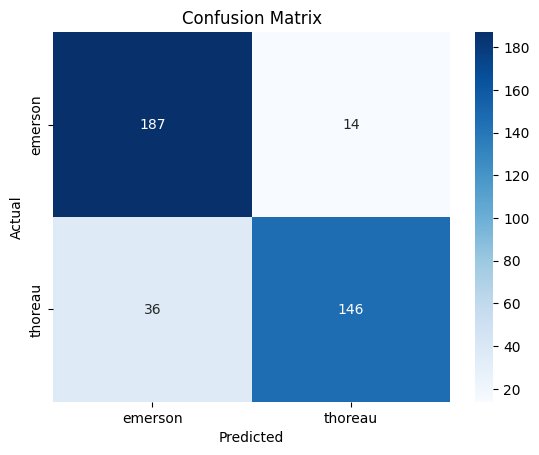

In [64]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [65]:
from sklearn import svm

In [66]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.86      0.90      0.88       201
     thoreau       0.88      0.84      0.86       182

    accuracy                           0.87       383
   macro avg       0.87      0.87      0.87       383
weighted avg       0.87      0.87      0.87       383

Test accuracy: 0.8720626631853786


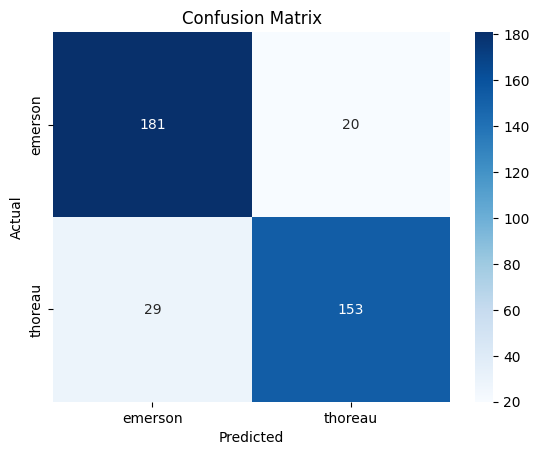

In [67]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [68]:

from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [70]:
!pip install -q datasets

In [71]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1914 entries, 146 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1914 non-null   object
 1   label   1914 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.9+ KB


,text,label
146,"If they\n\ncannot understand that, they cannot...",1
638,Life wastes itself whilst we are\n\npreparing ...,0
521,I took up the chip on which the three I have p...,1
409,The popular notion certainly adds a condition ...,0
31,we_ know so much of\n\nthem as we do. The same...,1


In [72]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1531 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

In [85]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none" # prevent prompt to login to W & B
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-85-2241263378>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
192,0.218700
384,0.145700
576,0.362500
768,0.320200
960,0.323800


TrainOutput(global_step=960, training_loss=0.2741920789082845, metrics={'train_runtime': 44.7645, 'train_samples_per_second': 171.006, 'train_steps_per_second': 21.446, 'total_flos': 438369032629308.0, 'train_loss': 0.2741920789082845, 'epoch': 5.0})

In [86]:
# Save the model.
trainer.save_model('model')

In [87]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [88]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [89]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

thoreau: pred=thoreau, txt='If I seem to boast more than is becoming, my excuse is\n\nthat I brag for humanity rather than for myself; and my shortcomings\n\nand inconsistencies do not affect the truth of my statement.\n\n Notwithstanding much cant and hypocrisy,—chaff which I find it\n\ndifficult to separate from my wheat, but for which I am as sorry as any\n\nman,—I will breathe freely and stretch myself in this respect, it is\n\nsuch a relief to both the moral and physical system; and I am resolved\n\nthat I will not through humility become the devil’s attorney. I will\n\nendeavor to speak a good word for the truth. At Cambridge College the\n\nmere rent of a student’s room, which is only a little larger than my\n\nown, is thirty dollars each year, though the corporation had the\n\nadvantage of building thirty-two side by side and under one roof, and\n\nthe occupant suffers the inconvenience of many and noisy neighbors, and\n\nperhaps a residence in the fourth story.'
thoreau: pred=t

<ipython-input-88-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


In [90]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-88-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


thoreau: pred=thoreau, txt='If I seem to boast more than is becoming, my excuse is\n\nthat I brag for humanity rather than for myself; and my shortcomings\n\nand inconsistencies do not affect the truth of my statement.\n\n Notwithstanding much cant and hypocrisy,—chaff which I find it\n\ndifficult to separate from my wheat, but for which I am as sorry as any\n\nman,—I will breathe freely and stretch myself in this respect, it is\n\nsuch a relief to both the moral and physical system; and I am resolved\n\nthat I will not through humility become the devil’s attorney. I will\n\nendeavor to speak a good word for the truth. At Cambridge College the\n\nmere rent of a student’s room, which is only a little larger than my\n\nown, is thirty dollars each year, though the corporation had the\n\nadvantage of building thirty-two side by side and under one roof, and\n\nthe occupant suffers the inconvenience of many and noisy neighbors, and\n\nperhaps a residence in the fourth story.'
thoreau: pred=t

In [91]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-91-2635634608>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [92]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       129
           1       0.99      0.71      0.83       254

    accuracy                           0.81       383
   macro avg       0.82      0.85      0.80       383
weighted avg       0.87      0.81      0.81       383

Test accuracy: 0.8067885117493473


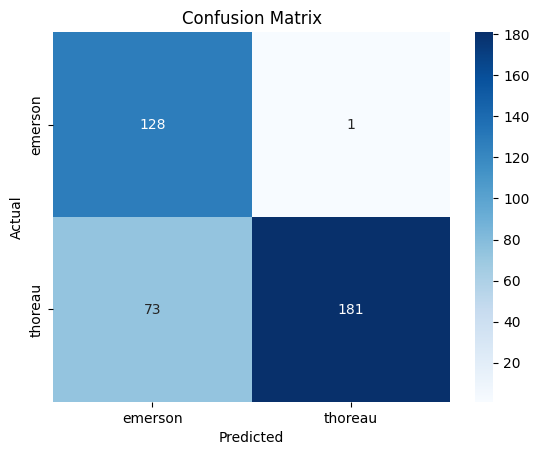

In [93]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [94]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [95]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [1, 1, 0, 1, 1]
y_pred_trans: [1, 1, 0, 1, 1]


In [96]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'He was always serene and\n\nthoughtful, impressing all who knew him with that spirituality which\n\nwas his most distinguishing characteristic.\n\n\n\n After graduating from college he taught school for a time, and then\n\nentered the Harvard Divinity School under Dr. Channing, the great\n\nUnitarian preacher. Although he was not strong enough to attend all\n\nthe lectures of the divinity course, the college authorities deemed\n\nthe name Emerson sufficient passport to the ministry.')
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'Whatever\n\noutrages have happened to men may befall a man again; and very easily\n\nin a republic, if there appear any signs of a decay of religion.\n\n Coarse slander, fire, tar and feathers, and the gibbet, the youth may\n\nfreely bring home to his mind, and with what sweetness of temper he\n\ncan, and inquire how fast he can fix his sense of duty, braving such\n\npenaltie

,actual,predicted,text
0,emerson,thoreau,"He was always serene and\n\nthoughtful, impres..."
1,emerson,thoreau,Whatever\n\noutrages have happened to men may ...
2,emerson,thoreau,But as every fact hath its roots\n\nin the sou...
3,emerson,thoreau,"His arrival in each place, the arrival of a ge..."
4,emerson,thoreau,I had better never see a book\n\nthan to be wa...
...,...,...,...
69,emerson,thoreau,Please check the Project Gutenberg web pages f...
70,emerson,thoreau,There is no\n\nchoice to genius. A great man d...
71,emerson,thoreau,It is a\n\ngreat satisfaction. A gentleman nev...
72,emerson,thoreau,he uses as\n\nif he were only a brick-kiln or ...
